Please find blackjax implementation of this notebook here:https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book2/11/mcmc_traceplots_unigauss.ipynb

jax version 0.3.13
jax backend cpu
Note: you may need to restart the kernel to use updated packages.


/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 1000/1000 [00:00<00:00, 1276.03it/s, 327 steps of size 5.80e-03. acc. prob=0.97]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
     alpha     24.92    441.83      0.22   -983.78    867.54     52.04      1.02
     sigma    735.89   2041.89    133.56      1.01   3162.79    163.15      1.03

Number of divergences: 28


/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


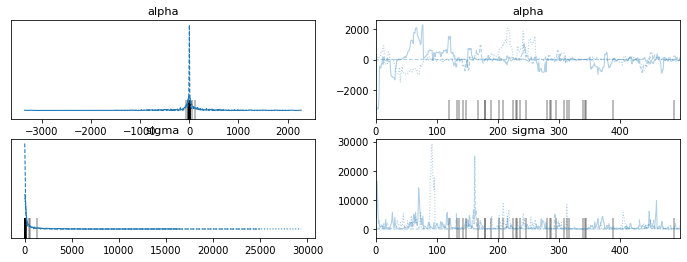

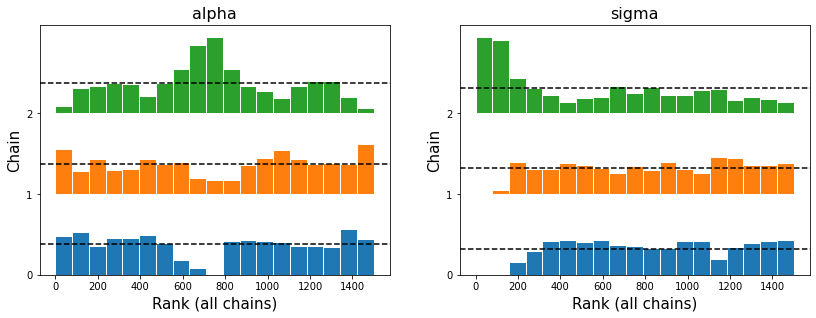

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 1000/1000 [00:00<00:00, 1482.90it/s, 7 steps of size 4.97e-01. acc. prob=0.91]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
     alpha      0.04      1.24      0.01     -2.43      2.87    344.99      1.02
     sigma      1.59      0.80      1.42      0.49      3.20    457.20      1.00

Number of divergences: 0


/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


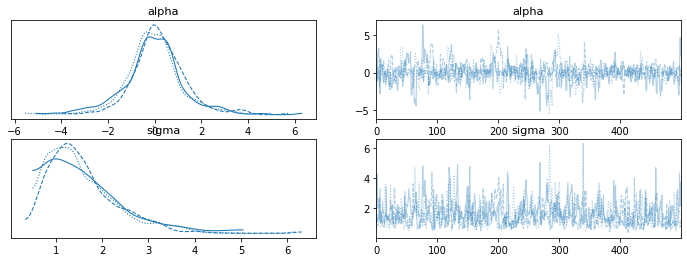

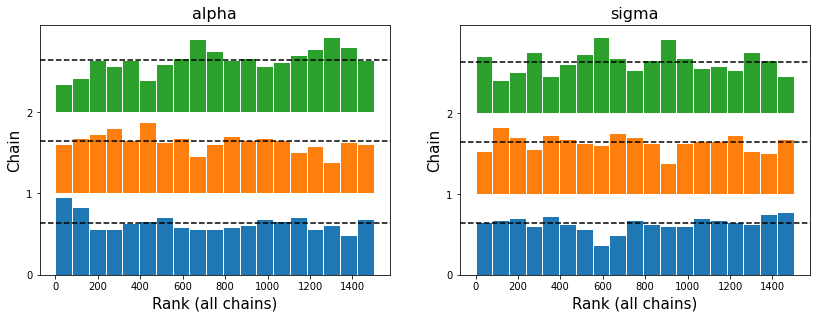

In [1]:

# We illustrate bad mixing MCMC chains using the example in sec 9.5  of
# [Statistical Rethinking ed 2](https://xcelab.net/rm/statistical-rethinking/).
# The numpyro code is from [Du Phan's site]
# https://fehiepsi.github.io/rethinking-numpyro/09-markov-chain-monte-carlo.html


import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import math
import os
import warnings
import pandas as pd

import jax
print("jax version {}".format(jax.__version__))
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))

import jax.numpy as jnp
from jax import random, vmap

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

try:
    import numpyro
except ModuleNotFoundError:
    %pip install -qq numpyro
    import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.distributions.transforms import AffineTransform
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim


try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

y = jnp.array([-1, 1])

# latexification of the figures is generated by notebooks/book2/11/mcmc_traceplots_unigauss.ipynb
# Below line is added so latexify status can be approved by script
pml.latexify(width_scale_factor=1, fig_height=2)

# Model with vague priors

def model(y):
    alpha = numpyro.sample("alpha", dist.Normal(0, 1000))
    sigma = numpyro.sample("sigma", dist.Exponential(0.0001))
    mu = alpha
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


m9_2 = MCMC(
    NUTS(model, target_accept_prob=0.95), num_warmup=500, num_samples=500, num_chains=3
)
m9_2.run(random.PRNGKey(11), y=y)

m9_2.print_summary(0.95)

az.plot_trace(az.from_numpyro(m9_2))
pml.savefig('mcmc_traceplot_unigauss_bad.png')
plt.show()

az.plot_rank(az.from_numpyro(m9_2))
pml.savefig('mcmc_trankplot_unigauss_bad.png')
plt.show()

# Model with proper priors

def model(y):
    alpha = numpyro.sample("alpha", dist.Normal(1, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = alpha
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


m9_3 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=3)
m9_3.run(random.PRNGKey(11), y=y)
m9_3.print_summary(0.95)

az.plot_trace(az.from_numpyro(m9_3))
pml.savefig('mcmc_traceplot_unigauss_good.png')
plt.show()

az.plot_rank(az.from_numpyro(m9_3))
pml.savefig('mcmc_trankplot_unigauss_good.png')
plt.show()


